In [108]:
import os
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from fairlearn.metrics import selection_rate, MetricFrame

In [109]:
print("🔄 CARGANDO MODELO Y DATOS DESDE MODELADO (RF)")
print("="*50)

try:
    # Cargar el modelo entrenado
    if os.path.exists("../Entrega3/models/randomforest_model.pkl"):
        modelo_rf = joblib.load("../Entrega3/models/randomforest_model.pkl")
        print("✅ Modelo RandomForest cargado desde archivo")
    else:
        print("⚠️ Archivo del modelo no encontrado. Ejecutar primero el notebook de modelado.")
        modelo_rf = None

    # Cargar datos originales
    data_path_rf = Path("../Entrega2/data/")
    df_rf = pd.read_csv(data_path_rf / "Titanic_Dataset_Featured.csv")
    print(f"✅ Dataset cargado: {df_rf.shape}")

    # Preprocessing
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    from sklearn.compose import ColumnTransformer

    X_rf = df_rf.drop('Survived', axis=1)
    y_rf = df_rf['Survived']

    numeric_features_rf = X_rf.select_dtypes(include=['int64', 'float64']).columns.tolist()
    all_categorical_rf = X_rf.select_dtypes(include=['object']).columns.tolist()
    variables_excluir_rf = ['Name', 'Ticket', 'Cabin', 'PassengerId']
    categorical_features_rf = [col for col in all_categorical_rf if col not in variables_excluir_rf]

    if 'PassengerId' in numeric_features_rf:
        numeric_features_rf.remove('PassengerId')

    features_seleccionadas_rf = numeric_features_rf + categorical_features_rf
    X_rf = X_rf[features_seleccionadas_rf]

    preprocessor_rf = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features_rf),
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features_rf)
        ]
    )

    X_train_rf, X_temp_rf, y_train_rf, y_temp_rf = train_test_split(
        X_rf, y_rf, test_size=0.4, random_state=42, stratify=y_rf
    )
    X_val_rf, X_test_rf, y_val_rf, y_test_rf = train_test_split(
        X_temp_rf, y_temp_rf, test_size=0.5, random_state=42, stratify=y_temp_rf
    )

    X_train_processed_rf = preprocessor_rf.fit_transform(X_train_rf)
    X_val_processed_rf = preprocessor_rf.transform(X_val_rf)
    X_test_processed_rf = preprocessor_rf.transform(X_test_rf)

    print(f"✅ Datos procesados:")
    print(f"   - Train: {X_train_processed_rf.shape}")
    print(f"   - Validation: {X_val_processed_rf.shape}")
    print(f"   - Test: {X_test_processed_rf.shape}")

    if modelo_rf is not None:
        y_pred_val_rf = modelo_rf.predict(X_val_processed_rf)
        y_pred_proba_val_rf = modelo_rf.predict_proba(X_val_processed_rf)[:, 1]

        y_pred_test_rf = modelo_rf.predict(X_test_processed_rf)
        y_pred_proba_test_rf = modelo_rf.predict_proba(X_test_processed_rf)[:, 1]

        print("✅ Predicciones generadas para validación y test")

    print("\n🎯 DATOS LISTOS PARA ANÁLISIS DE INTERPRETABILIDAD (RF)")

except Exception as e:
    print(f"❌ Error al cargar datos: {str(e)}")
    print("💡 Asegúrate de ejecutar primero el notebook de modelado")


🔄 CARGANDO MODELO Y DATOS DESDE MODELADO (RF)
✅ Modelo RandomForest cargado desde archivo
✅ Dataset cargado: (891, 36)
✅ Datos procesados:
   - Train: (534, 89)
   - Validation: (178, 89)
   - Test: (179, 89)
✅ Predicciones generadas para validación y test

🎯 DATOS LISTOS PARA ANÁLISIS DE INTERPRETABILIDAD (RF)


c:\Users\gerar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning:

Found unknown categories in columns [10, 11] during transform. These unknown categories will be encoded as all zeros

c:\Users\gerar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning:

Found unknown categories in columns [10] during transform. These unknown categories will be encoded as all zeros



1. DISPARIDAD DEMOGRÁFICA (Statistical Parity)

In [110]:
from fairlearn.metrics import selection_rate, MetricFrame
import plotly.graph_objects as go

y_pred_bin = (y_pred_proba_val_rf >= 0.5).astype(int)

grupos = {
    'Género': X_val_rf['Sex'],
    'Clase': X_val_rf['Pclass'],
    'Edad': (X_val_rf['Age'] < 18).map({True: 'Menor', False: 'Adulto'})
}

print("=== DISPARIDAD DEMOGRÁFICA (Statistical Parity) ===")
fig = go.Figure()
for nombre, grupo in grupos.items():
    mf = MetricFrame(metrics=selection_rate, y_true=y_val_rf, y_pred=y_pred_bin, sensitive_features=grupo)
    print("Selection Rate por grupo:")
    print(mf.by_group)
    print("Diferencia:", mf.difference())
    print("Ratio:", mf.ratio())
    fig.add_trace(go.Bar(x=list(mf.by_group.index), y=mf.by_group.values, name=nombre))
fig.update_layout(title="Selection Rate por Grupo Protegido", barmode='group')
fig.show()

=== DISPARIDAD DEMOGRÁFICA (Statistical Parity) ===
Selection Rate por grupo:
Sex
female    0.815385
male      0.115044
Name: selection_rate, dtype: float64
Diferencia: 0.7003403675970048
Ratio: 0.1410920020036734
Selection Rate por grupo:
Pclass
1    0.634146
2    0.540541
3    0.200000
Name: selection_rate, dtype: float64
Diferencia: 0.43414634146341463
Ratio: 0.3153846153846154
Selection Rate por grupo:
Age
Adulto    0.355705
Menor     0.448276
Name: selection_rate, dtype: float64
Diferencia: 0.09257116408238836
Ratio: 0.7934950955085183


2. IGUALDAD DE OPORTUNIDAD (Equal Opportunity)

In [111]:
from fairlearn.metrics import true_positive_rate

print("=== IGUALDAD DE OPORTUNIDAD (Equal Opportunity) ===")
fig = go.Figure()
for nombre, grupo in grupos.items():
    mf = MetricFrame(metrics=true_positive_rate, y_true=y_val_rf, y_pred=y_pred_bin, sensitive_features=grupo)
    print("True Positive Rate por grupo:")
    print(mf.by_group)
    fig.add_trace(go.Bar(x=list(mf.by_group.index), y=mf.by_group.values, name=nombre))
fig.update_layout(title="True Positive Rate por Grupo Protegido", barmode='group')
fig.show()

=== IGUALDAD DE OPORTUNIDAD (Equal Opportunity) ===
True Positive Rate por grupo:
Sex
female    0.897959
male      0.473684
Name: true_positive_rate, dtype: float64
True Positive Rate por grupo:
Pclass
1    0.888889
2    0.900000
3    0.523810
Name: true_positive_rate, dtype: float64
True Positive Rate por grupo:
Age
Adulto    0.732143
Menor     1.000000
Name: true_positive_rate, dtype: float64


3. ODDS EQUALIZADOS (Equalized Odds)

In [112]:
from fairlearn.metrics import false_positive_rate

print("=== ODDS EQUALIZADOS (Equalized Odds) ===")
for nombre, grupo in grupos.items():
    mf = MetricFrame(
        metrics={"TPR": true_positive_rate, "FPR": false_positive_rate},
        y_true=y_val_rf, y_pred=y_pred_bin, sensitive_features=grupo
    )
    print("TPR y FPR por grupo:")
    print(mf.by_group)
    # Visualización
    fig = go.Figure()
    fig.add_trace(go.Bar(x=list(mf.by_group.index), y=mf.by_group["TPR"], name=f"{nombre} - TPR"))
    fig.add_trace(go.Bar(x=list(mf.by_group.index), y=mf.by_group["FPR"], name=f"{nombre} - FPR"))
    fig.update_layout(title=f"TPR y FPR por {nombre}", barmode='group')
    fig.show()

=== ODDS EQUALIZADOS (Equalized Odds) ===
TPR y FPR por grupo:
             TPR       FPR
Sex                       
female  0.897959  0.562500
male    0.473684  0.042553


TPR y FPR por grupo:
             TPR       FPR
Pclass                    
1       0.888889  0.142857
2       0.900000  0.117647
3       0.523810  0.113924


TPR y FPR por grupo:
             TPR       FPR
Age                       
Adulto  0.732143  0.129032
Menor   1.000000  0.058824


4. CALIBRACIÓN POR GRUPO

=== CALIBRACIÓN POR GRUPO ===


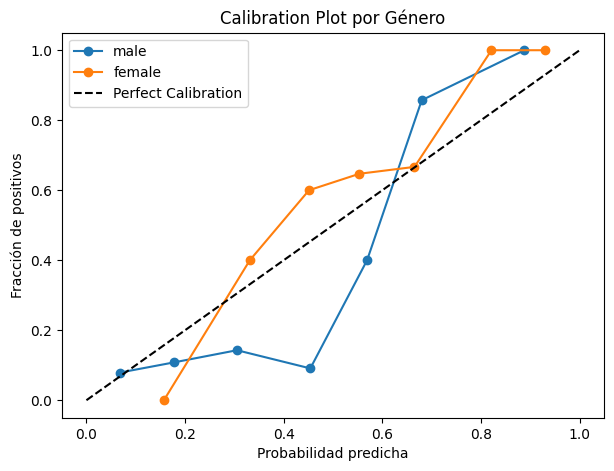

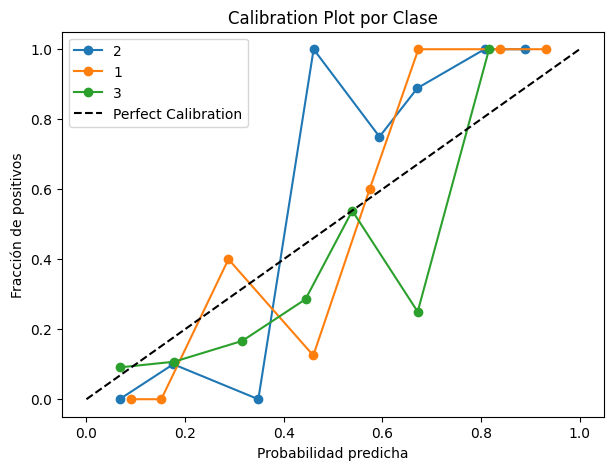

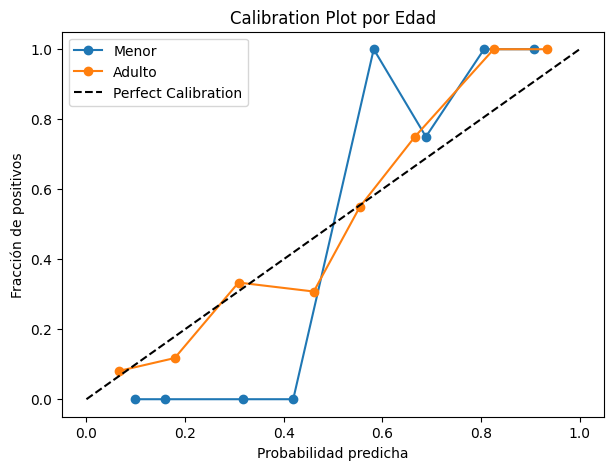

In [113]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

print("=== CALIBRACIÓN POR GRUPO ===")
for nombre, grupo in grupos.items():
    plt.figure(figsize=(7,5))
    for g in grupo.unique():
        mask = grupo == g
        probas = y_pred_proba_val_rf[mask]
        y_true_g = y_val_rf[mask]
        frac_pos, mean_pred = calibration_curve(y_true_g, probas, n_bins=8)
        plt.plot(mean_pred, frac_pos, marker='o', label=f'{g}')
    plt.plot([0,1],[0,1],'k--',label='Perfect Calibration')
    plt.xlabel('Probabilidad predicha')
    plt.ylabel('Fracción de positivos')
    plt.title(f'Calibration Plot por {nombre}')
    plt.legend()
    plt.show()

In [114]:
from fairlearn.metrics import selection_rate, MetricFrame, true_positive_rate, false_positive_rate
from sklearn.metrics import precision_score
import pandas as pd

# Definir los grupos
grupos = {
    'Género': X_val_rf['Sex'],
    'Clase': X_val_rf['Pclass'],
    'Edad': (X_val_rf['Age'] < 18).map({True: 'Menor', False: 'Adulto'})
}

# Inicializar lista para la tabla
tabla_fairness = []

for nombre, grupo in grupos.items():
    # Métricas por grupo
    mf_tpr = MetricFrame(metrics=true_positive_rate, y_true=y_val_rf, y_pred=y_pred_bin, sensitive_features=grupo)
    mf_fpr = MetricFrame(metrics=false_positive_rate, y_true=y_val_rf, y_pred=y_pred_bin, sensitive_features=grupo)
    mf_prec = MetricFrame(metrics=precision_score, y_true=y_val_rf, y_pred=y_pred_bin, sensitive_features=grupo)
    mf_dempar = MetricFrame(metrics=selection_rate, y_true=y_val_rf, y_pred=y_pred_bin, sensitive_features=grupo)
    
    for g in mf_tpr.by_group.index:
        tabla_fairness.append({
            'Grupo': f"{nombre}: {g}",
            'TPR': round(mf_tpr.by_group[g], 2),
            'FPR': round(mf_fpr.by_group[g], 2),
            'Precision': round(mf_prec.by_group[g], 2),
            'Dem.Par.': round(mf_dempar.by_group[g], 2)
        })

# Crear DataFrame
df_fairness = pd.DataFrame(tabla_fairness)
print("Tabla de Fairness por Grupo:")
print(df_fairness)

Tabla de Fairness por Grupo:
            Grupo   TPR   FPR  Precision  Dem.Par.
0  Género: female  0.90  0.56       0.83      0.82
1    Género: male  0.47  0.04       0.69      0.12
2        Clase: 1  0.89  0.14       0.92      0.63
3        Clase: 2  0.90  0.12       0.90      0.54
4        Clase: 3  0.52  0.11       0.55      0.20
5    Edad: Adulto  0.73  0.13       0.77      0.36
6     Edad: Menor  1.00  0.06       0.92      0.45


In [115]:
# Bloque 6: Simulación de Asignación de Botes Salvavidas

X_val_rf['proba_pred'] = y_pred_proba_val_rf
df_val_sorted = X_val_rf.sort_values('proba_pred', ascending=False)
n_botes = int(0.5 * len(X_val_rf))  # Simula 50% de capacidad

df_val_sorted['asignado_bote'] = 0
df_val_sorted.iloc[:n_botes, df_val_sorted.columns.get_loc('asignado_bote')] = 1

# Comparar demografía de asignados vs. no asignados
print(df_val_sorted.groupby('asignado_bote')['Sex'].value_counts(normalize=True))
print(df_val_sorted.groupby('asignado_bote')['Pclass'].value_counts(normalize=True))

asignado_bote  Sex   
0              male      0.955056
               female    0.044944
1              female    0.685393
               male      0.314607
Name: proportion, dtype: float64
asignado_bote  Pclass
0              3         0.775281
               2         0.157303
               1         0.067416
1              1         0.393258
               3         0.348315
               2         0.258427
Name: proportion, dtype: float64


Tasa de supervivencia real y predicha por género y clase:
Female Clase 1: Real=1.00, Predicha=1.00
Female Clase 2: Real=0.94, Predicha=0.94
Female Clase 3: Real=0.48, Predicha=0.62
Male Clase 1: Real=0.36, Predicha=0.32
Male Clase 2: Real=0.20, Predicha=0.20
Male Clase 3: Real=0.10, Predicha=0.03

Tasa de supervivencia real y predicha para niños por clase:
Niño Clase 1: Real=nan, Predicha=nan
Niño Clase 2: Real=1.00, Predicha=1.00
Niño Clase 3: Real=0.18, Predicha=0.27

Tasa de supervivencia real y predicha para ancianos por género y clase:
Anciano Female Clase 1: Real=1.00, Predicha=1.00
Anciano Female Clase 2: Real=nan, Predicha=nan
Anciano Female Clase 3: Real=nan, Predicha=nan
Anciano Male Clase 1: Real=0.00, Predicha=0.33
Anciano Male Clase 2: Real=1.00, Predicha=0.00
Anciano Male Clase 3: Real=nan, Predicha=nan


C:\Users\gerar\AppData\Local\Temp\ipykernel_11960\3390872915.py:25: RuntimeWarning:

Mean of empty slice.

c:\Users\gerar\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\gerar\AppData\Local\Temp\ipykernel_11960\3390872915.py:34: RuntimeWarning:

Mean of empty slice.



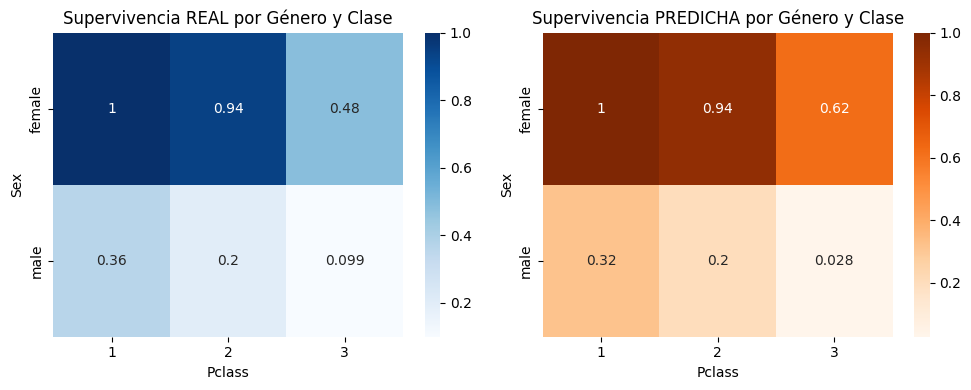

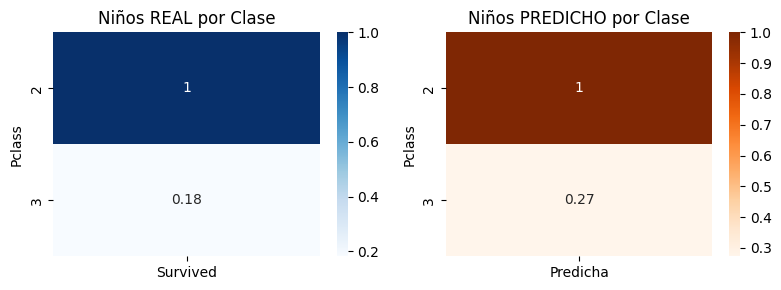

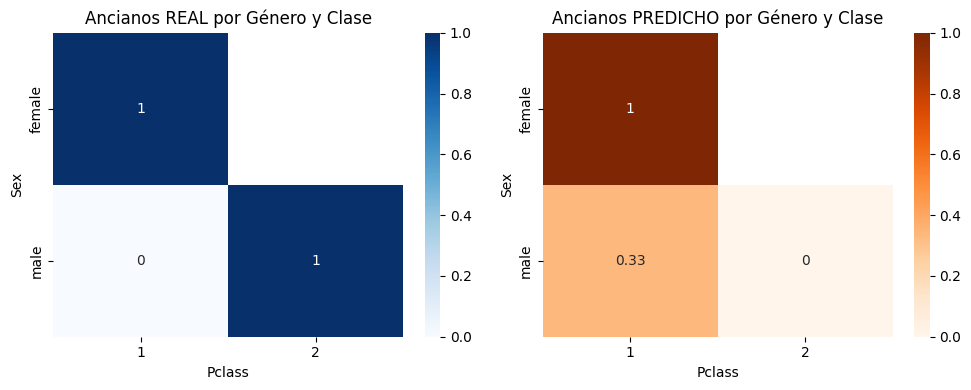

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

# Añadir la columna 'Survived' al DataFrame de validación si no existe
if 'Survived' not in X_val_rf.columns:
    X_val_rf['Survived'] = y_val_rf.values

# Categoría de edad
X_val_rf['Edad_cat'] = pd.cut(X_val_rf['Age'], bins=[0, 12, 18, 60, 100], labels=['Niño', 'Adolescente', 'Adulto', 'Anciano'])

# 1. Mujeres y hombres por clase (1ra, 2da, 3ra)
print("Tasa de supervivencia real y predicha por género y clase:")
for sexo in ['female', 'male']:
    for clase in [1, 2, 3]:
        mask = (X_val_rf['Sex'] == sexo) & (X_val_rf['Pclass'] == clase)
        real = X_val_rf.loc[mask, 'Survived'].mean()
        pred = y_pred_bin[mask].mean()
        print(f"{sexo.title()} Clase {clase}: Real={real:.2f}, Predicha={pred:.2f}")

# 2. Niños por clase
print("\nTasa de supervivencia real y predicha para niños por clase:")
for clase in [1, 2, 3]:
    mask = (X_val_rf['Edad_cat'] == 'Niño') & (X_val_rf['Pclass'] == clase)
    real = X_val_rf.loc[mask, 'Survived'].mean()
    pred = y_pred_bin[mask].mean()
    print(f"Niño Clase {clase}: Real={real:.2f}, Predicha={pred:.2f}")

# 3. Ancianos por género y clase
print("\nTasa de supervivencia real y predicha para ancianos por género y clase:")
for sexo in ['female', 'male']:
    for clase in [1, 2, 3]:
        mask = (X_val_rf['Edad_cat'] == 'Anciano') & (X_val_rf['Sex'] == sexo) & (X_val_rf['Pclass'] == clase)
        real = X_val_rf.loc[mask, 'Survived'].mean()
        pred = y_pred_bin[mask].mean()
        print(f"Anciano {sexo.title()} Clase {clase}: Real={real:.2f}, Predicha={pred:.2f}")

# Heatmap de tasas de supervivencia real vs. predicha por género y clase
tabla_real = X_val_rf.pivot_table(values='Survived', index='Sex', columns='Pclass', aggfunc='mean')
tabla_pred = pd.DataFrame({'Sex': X_val_rf['Sex'], 'Pclass': X_val_rf['Pclass'], 'Predicha': y_pred_bin}).pivot_table(values='Predicha', index='Sex', columns='Pclass', aggfunc='mean')

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.heatmap(tabla_real, annot=True, cmap='Blues')
plt.title('Supervivencia REAL por Género y Clase')
plt.subplot(1,2,2)
sns.heatmap(tabla_pred, annot=True, cmap='Oranges')
plt.title('Supervivencia PREDICHA por Género y Clase')
plt.tight_layout()
plt.show()

# Heatmap de niños por clase
tabla_ninos_real = X_val_rf[X_val_rf['Edad_cat']=='Niño'].pivot_table(values='Survived', index='Pclass', aggfunc='mean')
tabla_ninos_pred = pd.DataFrame({'Pclass': X_val_rf['Pclass'], 'Edad_cat': X_val_rf['Edad_cat'], 'Predicha': y_pred_bin})
tabla_ninos_pred = tabla_ninos_pred[tabla_ninos_pred['Edad_cat']=='Niño'].pivot_table(values='Predicha', index='Pclass', aggfunc='mean')

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
sns.heatmap(tabla_ninos_real, annot=True, cmap='Blues')
plt.title('Niños REAL por Clase')
plt.subplot(1,2,2)
sns.heatmap(tabla_ninos_pred, annot=True, cmap='Oranges')
plt.title('Niños PREDICHO por Clase')
plt.tight_layout()
plt.show()

# Heatmap de ancianos por género y clase
tabla_ancianos_real = X_val_rf[X_val_rf['Edad_cat']=='Anciano'].pivot_table(values='Survived', index='Sex', columns='Pclass', aggfunc='mean')
tabla_ancianos_pred = pd.DataFrame({'Sex': X_val_rf['Sex'], 'Pclass': X_val_rf['Pclass'], 'Edad_cat': X_val_rf['Edad_cat'], 'Predicha': y_pred_bin})
tabla_ancianos_pred = tabla_ancianos_pred[tabla_ancianos_pred['Edad_cat']=='Anciano'].pivot_table(values='Predicha', index='Sex', columns='Pclass', aggfunc='mean')

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.heatmap(tabla_ancianos_real, annot=True, cmap='Blues')
plt.title('Ancianos REAL por Género y Clase')
plt.subplot(1,2,2)
sns.heatmap(tabla_ancianos_pred, annot=True, cmap='Oranges')
plt.title('Ancianos PREDICHO por Género y Clase')
plt.tight_layout()
plt.show()